In [1]:
## IMPORTANT ##
# For the BERT model, it appears that you do not need to lemmatize/remove stopwords/do traditional NLP preprocessing:
# https://stackoverflow.com/questions/63979544/using-trained-bert-model-and-data-preprocessing
# Therefore, when we are using this transfer learning model, simply import and go

import pandas as pd
import numpy as np
import torch
import torch.utils.data as DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

from tqdm.auto import tqdm

from datasets import Dataset

import evaluate

file_path = "/Users/colden/Documents/VSCode/npo_classifier-master/My_Code/Environment_Data.csv"
data = pd.read_csv(file_path)

#set value to 1 if env is 1 or 2, else set to 0
data['env'] = data['env'].apply(lambda x: 1 if x in [1, 2] else 0)
data = data.rename(columns={'p3orgpur': 'description'})
data['orig_description'] = data['description']
data['description'] = data['name'] + '. ' + data['description'].fillna('')

print("don't forget to uncomment the above line! to include title")
#print('\n\n Value Counts, 0 is not env, 1 is env: ')
#print(data['env'].value_counts())


/Users/colden/Documents/VSCode/npo_classifier-master/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/colden/Documents/VSCode/npo_classifier-master/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


don't forget to uncomment the above line! to include title


In [2]:
#pd.set_option('display.max_colwidth', None)
#print(data['description'].info())
from sklearn.model_selection import train_test_split

data_trimmed = data[['description', 'env']]

data_trimmed = data_trimmed.sample(n=1500, random_state = 0) # this is for testing purposes
print("drop the above line to use all data!")

train_data, test_data = train_test_split(data_trimmed, test_size=0.2, random_state=0)


print("len training data is: ", len(train_data), "len testing data is: ", len(test_data))

print("This number should be zero: ", data["description"].isnull().sum())



drop the above line to use all data!
len training data is:  1200 len testing data is:  300
This number should be zero:  0


In [3]:
print(len(data))

27351


In [4]:
# Convert from pandas to Huggingface Dataset

HF_train_data = Dataset.from_pandas(train_data)
HF_test_data = Dataset.from_pandas(test_data)

# access dataset pieces
#print(HF_train_data[0])
#print(data_trimmed.iloc[[20676]])

# the bert model is loaded from: https://huggingface.co/google-bert
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")  # likely want bert-base-uncased or bert-large-uncased
# if using uncased, maybe have to change input to lowercase as well?? some guy on stackoverflow says
# can also use bert-base-uncased (maybe better?? need to see what's different), bert-large-uncased

# tokenizer.verbose = True

def find_max_length(data):
    max_length = 0
    for item in data:
        length = len(tokenizer.tokenize(item["description"]))
        if length > max_length:
            max_length = length
    return int(max_length)
 
def tokenize_dataset(data):
    return tokenizer(text=data["description"],
                     max_length=None, # this defaults to max model length, in this case 512 # Try also with some different numbers!
                     truncation=True,
                     padding = 'max_length')
# Hugging Face documentation: "In most cases, padding your batch to the length of the longest sequence and truncating to the maximum length a model can accept works pretty well."

train_data_tokenized = HF_train_data.map(tokenize_dataset) # batched=True/False if speed is an issue
test_data_tokenized = HF_test_data.map(tokenize_dataset)

print("Try changing the max length. Try changing to a different 'pretrained' model")

Map: 100%|██████████| 300/300 [00:00<00:00, 5281.79 examples/s]

Try changing the max length. Try changing to a different 'pretrained' model


In [5]:

#print(train_data_tokenized)
#print(test_data_tokenized)

train_data_tokenized = train_data_tokenized.remove_columns(["description", "__index_level_0__"])
test_data_tokenized = test_data_tokenized.remove_columns(["description", "__index_level_0__"])

train_data_tokenized = train_data_tokenized.rename_column("env", "labels")
test_data_tokenized = test_data_tokenized.rename_column("env", "labels")

train_data_tokenized.set_format("torch")
test_data_tokenized.set_format("torch")

print("train_data_tokenized: ", train_data_tokenized)
print("test_data_tokenized: ", test_data_tokenized)


train_data_tokenized:  Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1200
})
test_data_tokenized:  Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 300
})


In [6]:
torch.cuda.empty_cache()

training_data_loader = DataLoader.DataLoader(dataset = train_data_tokenized, batch_size=32, shuffle=True) # play with batch size
testing_data_loader = DataLoader.DataLoader(dataset = test_data_tokenized, batch_size=32, shuffle=False)

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2) # again, change bert-base-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
epochs = 20 # increase, graph

total_training_steps = epochs * len(training_data_loader) # calculate the total number of training steps

optimizer = AdamW(model.parameters(), lr=0.5) # This is really important to do different values of .00005

lr_scheduler = get_scheduler(name = "linear",
                             optimizer = optimizer,
                             num_warmup_steps = 0,
                             num_training_steps = total_training_steps)

progress_bar = tqdm(range(total_training_steps), desc="Training", position=0, leave=True)

# don't understand this stuff below: look at it later
model.train()
for epoch in range(epochs):
    for batch in training_data_loader:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)




Training:  81%|████████  | 614/760 [7:44:50<1:51:16, 45.73s/it]

: 

In [ ]:
torch.save(model, "/Users/colden/Documents/VSCode/npo_classifier-master/My_Code/BERT_Model")
# model = torch.load("/Users/colden/Documents/VSCode/npo_classifier-master/My_Code/BERT_Model")



In [ ]:
model_test = torch.load("/Users/colden/Documents/VSCode/npo_classifier-master/My_Code/BERT_Model")


In [ ]:
model.eval()

total_correct = 0
total_examples = 0



for batch in testing_data_loader:
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'orig_description'}
    labels = inputs['labels']
    
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_probs = outputs.logits.softmax(dim=1)
        predicted_labels = predicted_probs.argmax(dim=1)
    
    total_correct += (predicted_labels == labels).sum().item()
    total_examples += labels.size(0)

accuracy = total_correct / total_examples
print(f"Accuracy: {accuracy}")

# Current accuracy: 0.7315 with 20000 1 epoch (Bert_model)



Accuracy: 0.7315


In [ ]:
from datasets import load_metric

metric1 = load_metric("accuracy")
metric2 = load_metric("f1")
metric3 = load_metric("precision")

model.eval()

logits_all = []
predicted_probs_all = []
predictions_all = []

for batch in testing_data_loader:
    batch = {k: v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    logits_all.append(logits)
    predicted_probs = torch.softmax(logits, dim=1)
    predicted_probs_all.append(predicted_probs)
    predictions = torch.argmax(predicted_probs, dim=-1)
    predictions_all.append(predictions)

    metric1.add_batch(predictions=predictions, references=batch["labels"])
    metric2.add_batch(predictions=predictions, references=batch["labels"])
    metric3.add_batch(predictions=predictions, references=batch["labels"])


print("Accuracy: ", metric1.compute())
print("F1: ", metric2.compute())
print("Precision: ", metric3.compute())

/Users/colden/Documents/VSCode/npo_classifier-master/.venv/lib/python3.9/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/colden/Documents/VSCode/npo_classifier-master/.venv/lib/python3.9/site-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=Tr

Accuracy:  {'accuracy': 0.7315}
F1:  {'f1': 0.0}
Precision:  {'precision': 0.0}


/Users/colden/Documents/VSCode/npo_classifier-master/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch


# Set the model to evaluation mode
model.eval()

# Convert the input data to tensors
input_ids = torch.tensor(HF_test_data['input_ids'])
attention_mask = torch.tensor(HF_test_data['attention_mask'])
token_type_ids = torch.tensor(HF_test_data['token_type_ids'])

# Make predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

# Get the predicted probabilities
predicted_probs = torch.softmax(outputs.logits, dim=1)

# Convert the predicted probabilities to a numpy array
predicted_probs = predicted_probs.numpy()

# Print the predicted probabilities
print(predicted_probs)

In [ ]:
print(predicted_probs_all)

[tensor([[0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251]]), tensor([[0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [0.9749, 0.0251],
        [

In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix

# Assuming y_true are your true labels and y_pred are the predicted labels
y_true = [...]
y_pred = [...]

cm = confusion_matrix(y_true, y_pred)

print(cm)


##

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

ValueError: unknown is not supported

In [ ]:
# delete all



import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag

data['description'] = data['description'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

stop_words = set()
stop_words.add('s')
stop_words.add('nan')


# Remove stopwords from the description
data['description'] = data['description'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words]))

# lematize function - taken from IBM: https://www.ibm.com/topics/stemming-lemmatization#:~:text=The%20practical%20distinction%20between%20stemming,be%20found%20in%20the%20dictionary.
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN

def lemmatize_passage(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence

data['description'] = data['description'].apply(lemmatize_passage)
print("/n/n Lemmatized Data: ")
print(data['description'].head(5))




/n/n Lemmatized Data: 
0    PARTNERSHIP SUSTAINABLE METHOW PROMOTE SUSTAIN...
1    LANDSCAPE ARCHITECTURE FOUNDATION PROMOTE EDUC...
2    FRIENDS ACADIA ASSURE ENDURING PROTECTION APPR...
3    OKLAHOMA AQUARIUM FOUNDATION build support aqu...
4    CORNWALL CONSERVATION TRUST INC CHARITABLE PRO...
Name: description, dtype: object


In [ ]:
# this code is nearly duplicate: need to remove some stuff from above (integrate the data cleaning into this function)
# need to drop nan values
corpus = []
data_clipped = data[['description', 'env']]
for i in range(len(data_clipped)):
    row = data_clipped.iloc[i]
    summary = row['description'].lower()
    summary = summary.split()
    clean_summary = ' '.join(summary)
    corpus.append(clean_summary)
    #print(row['env'])
    

corpus[1]

'landscape architecture foundation promote education research landscape architecture'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

input_size = 1500 # number of words to keep -- note that this is also what is fed into the neural network as input size

vectorizer = TfidfVectorizer(max_features=input_size, min_df=3, max_df=0.8) #max features is number of words to keep, min_df is min # of documents a word must appear in, max_df is max percentage of documents a word can appear in
X = vectorizer.fit_transform(corpus).toarray()
print(len(X)) # desc column vectorized

y = data_clipped.iloc[:, 1].values #env column
print(len(y))

27351
27351


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

corpus_indices = np.arange(len(corpus))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, corpus_indices, test_size=0.2, random_state=0)


# How to print training data corresponding to corpus
# print(idx_test[0]) # index of first test data
# print(corpus[idx_test[0]]) # mechanism to print the first test data


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()



In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(input_size) # number of words in the vectorized data
output_size = 2 # binary classification -- maybe needs to be changed to get percentages?
hidden_size = 500 # number of neurons in the hidden layer -- this should be tweaked

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

model = Net()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss() # CrossEntropyLoss() is the same as NLLLoss() with log_softmax ?

torch.Size([21880, 1500]) torch.Size([21880])
torch.Size([5471, 1500]) torch.Size([5471])
1500


/Users/colden/Documents/VSCode/npo_classifier-master/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/colden/Documents/VSCode/npo_classifier-master/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
epochs = 100
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model(X_train)
    loss = loss_fn(Y_pred, y_train.long())
    losses.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    


    if epoch % 10 == 0:
        print(f'Epoch {epoch} / {epochs}, Loss: {loss.item()}')




Epoch 0 / 100, Loss: 0.7031731009483337
Epoch 10 / 100, Loss: 0.26562267541885376
Epoch 20 / 100, Loss: 0.20463494956493378
Epoch 30 / 100, Loss: 0.14434000849723816
Epoch 40 / 100, Loss: 0.08826933056116104
Epoch 50 / 100, Loss: 0.04358929023146629
Epoch 60 / 100, Loss: 0.017664194107055664
Epoch 70 / 100, Loss: 0.012916555628180504
Epoch 80 / 100, Loss: 0.010071254335343838
Epoch 90 / 100, Loss: 0.008332142606377602


Text(0.5, 0, 'Epoch')

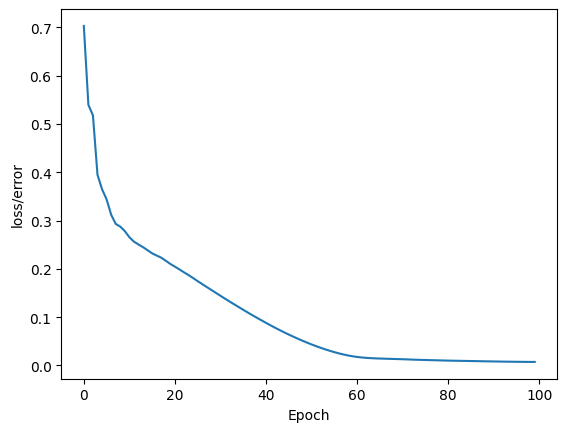

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

In [ ]:
# predictions
with torch.no_grad():
    Y_eval = model.forward(X_test)
    loss = loss_fn(Y_eval, y_test.long())

print(loss)


tensor(0.9189)


In [ ]:
print(y_test[3])

tensor(1.)


In [ ]:
# correct = 0
# false = 0
# with torch.no_grad():
#     for i, data in enumerate(X_test):
#         y_val = model.forward(data)
#         print(f'{i+1}. {str(y_val)}, predicted {y_val.argmax().item()}, actual {y_test[i]}')

#         if y_val.argmax().item() == y_test[i]:
#             correct += 1
#         else: 
#             false += 1
        
        

# print(f'Correct: {correct}, False: {false}')

# print(f'Accuracy: {correct / (correct + false)}')





correct = 0
false = 0
false_prediction_0 = 0
uncertain = 0
threshold = 0.3

values_to_investigate = [] # list of indices to investigate further
actual_values_to_investigate = [] # list of actual values to investigate further
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        predicted_class = y_val.argmax().item()
        actual_class = y_test[i].item()

        #print(f'{i+1}. {str(y_val)}, predicted {predicted_class}, actual {actual_class}')

        #print(y_val[0].item())
        #print(y_val[1].item())
        if abs(y_val[0].item() - y_val[1].item()) < threshold:
               print(f'{i+1}. {str(y_val)}, predicted {predicted_class}, actual {actual_class}')
               uncertain += 1
        elif predicted_class == actual_class:
           correct += 1
        elif predicted_class != actual_class:
            if predicted_class == 0:
               false_prediction_0 += 1
            else:
               values_to_investigate.append(i) # paste these elsewhere to look at a different set of values of interest
               actual_values_to_investigate.append(actual_class)
            false += 1
        else: 
           print('error')


        
        

print(f'Correct: {correct}, False: {false}, Uncertain: {uncertain}')
print(f'False prediction 0: {false_prediction_0}, False prediction 1: {false - false_prediction_0}')

print(f'Accuracy: {(correct + uncertain) / (correct + false + uncertain)}')

# currently, TfidfVectorizer is used to train the model. However, this is a bag of words model, which does not take into account the context of the words.
# This is a limitation of the model. A better model might be a word2vec, BERT, FastText, Glove, etc. model, which takes into account the context of the words.
# would also be nice to see which tensor goes with which word

13. tensor([-0.7523, -0.6373]), predicted 1, actual 0.0
35. tensor([-0.6272, -0.7638]), predicted 0, actual 0.0
901. tensor([-0.7600, -0.6305]), predicted 1, actual 0.0
1111. tensor([-0.8139, -0.5854]), predicted 1, actual 1.0
1181. tensor([-0.7144, -0.6724]), predicted 1, actual 0.0
1398. tensor([-0.7519, -0.6376]), predicted 1, actual 1.0
1408. tensor([-0.6549, -0.7329]), predicted 0, actual 0.0
1592. tensor([-0.8295, -0.5732]), predicted 1, actual 1.0
1955. tensor([-0.6975, -0.6888]), predicted 1, actual 1.0
2068. tensor([-0.5816, -0.8188]), predicted 0, actual 0.0
2115. tensor([-0.7144, -0.6724]), predicted 1, actual 0.0
2823. tensor([-0.6903, -0.6960]), predicted 0, actual 1.0
2896. tensor([-0.7896, -0.6052]), predicted 1, actual 0.0
2939. tensor([-0.6596, -0.7278]), predicted 0, actual 0.0
2980. tensor([-0.6118, -0.7817]), predicted 0, actual 1.0
2986. tensor([-0.5994, -0.7966]), predicted 0, actual 0.0
3043. tensor([-0.7942, -0.6014]), predicted 1, actual 0.0
3223. tensor([-0.62

In [ ]:
def pred_value(input):
    input = vectorizer.transform(input).toarray()
    input = torch.from_numpy(input).float()
    output = model(input)
    return str(output) + ' , predicted:' + str(output.argmax().item())

#print(pred_value(["foster a work environment"]))
#print(pred_value(["nan"]))


# Prints the corpus value at an index
def investigate_value(investigate_value):
    print(corpus[idx_test[investigate_value]])
    print(pred_value([corpus[idx_test[investigate_value]]]))

i = 0
for index in values_to_investigate:
    investigate_value(index)
    print(f'Actual: {actual_values_to_investigate[i]}')
    i += 1


west bend beautification committee inc beautification city west bend
tensor([[-4.0026, -0.0184]], grad_fn=<LogSoftmaxBackward0>) , predicted:1
Actual: 0.0
pittsfield education foundation purpose corporation organize shall object corporation organize carry exclusively charitable activity within mean sections 170c3 internal revenue code 1986 code
tensor([[-5.7051e+00, -3.3346e-03]], grad_fn=<LogSoftmaxBackward0>) , predicted:1
Actual: 0.0
improved solutions urban systems research develop demonstrate innovative approaches solving problems related economic development self sufficiency
tensor([[-8.4697e+00, -2.0979e-04]], grad_fn=<LogSoftmaxBackward0>) , predicted:1
Actual: 0.0
aua fisheries development project inc train educate native samoans
tensor([[-5.9984e+00, -2.4856e-03]], grad_fn=<LogSoftmaxBackward0>) , predicted:1
Actual: 0.0
coalition health environments research promote fund disseminate research humane effective efficient environments multidisciplinary collaboration dedicated qu